In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from joblib import dump
from pathlib import Path
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from IPython.display import display

from ml_model import PipelineManager
from utils.GPU_models import KerasClassifierModel, gpu_model_hub
from utils.preprocessing_utils import preprocess_notas, merge_classes, word_count_feat_engineering
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
retrain_with_class_weight=False
add_gpu_prediction = True

## Data setup

In [3]:
df_notas = preprocess_notas(pd.read_csv('../data/notas.csv', sep=';'))
df_laboratorios = pd.read_csv('../data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('../data/sociodemografico.csv', sep=';')

In [4]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS - F...
1,45038.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES 2 MESES 202006021580194...
2,40391.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria ve pertinente seguimiento dentro mes m...
3,106350.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. formula TAR (TDF/FTC+EFV) 2. S/S Paraclini...
4,105840.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACION brinda retroalimentacion relacion r...


In [5]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [7]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600.0,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS - F...
1,45038.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES 2 MESES 202006021580194...
2,40391.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria ve pertinente seguimiento dentro mes m...
3,106350.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. formula TAR (TDF/FTC+EFV) 2. S/S Paraclini...
4,105840.0,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACION brinda retroalimentacion relacion r...


### Merge all datasets

In [8]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"explica acerca programa, recomienda adherencia..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente diagnostico. Reforz...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL CADA FOSA NASA...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO MES-INFECTOLOGIA VALORACIOJN IN...


## Feature Engineering

In [9]:
df_merge = merge_classes(df_merge)
df_merge = word_count_feat_engineering(df_merge)
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,...,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,1
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,...,0,0,0,0,0,0,1,0,0,0


## Label encoding

In [10]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 3685, 60586, 49378,  6278, 17437,  2808]))

## Train-test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Further feature engineering

Epoch 1/400
Epoch 2/400
Epoch 3/400
Epoch 4/400
Epoch 5/400
Epoch 6/400
Epoch 7/400
Epoch 8/400
Epoch 9/400
Epoch 10/400
Epoch 11/400
Epoch 12/400
Epoch 13/400
Epoch 14/400
Epoch 15/400
Epoch 16/400
Epoch 17/400
Epoch 18/400
Epoch 19/400
Epoch 20/400
Epoch 21/400
Epoch 22/400
Epoch 23/400
Epoch 24/400
Epoch 25/400
Epoch 26/400
Epoch 27/400
Epoch 28/400
Epoch 29/400
Epoch 30/400
Epoch 31/400
Epoch 32/400
Epoch 33/400
Epoch 34/400
Epoch 35/400
Epoch 36/400
Epoch 37/400
Epoch 38/400
Epoch 39/400
Epoch 40/400
Epoch 41/400
Epoch 42/400
Epoch 43/400
Epoch 44/400
Epoch 45/400
Epoch 46/400
Epoch 47/400
Epoch 48/400
Epoch 49/400
Epoch 50/400
Epoch 51/400
Epoch 52/400
Epoch 53/400
Epoch 54/400
Epoch 55/400
Epoch 56/400
Epoch 57/400
Epoch 58/400
Epoch 59/400
Epoch 60/400
Epoch 61/400
Epoch 62/400
Epoch 63/400
Epoch 64/400
Epoch 65/400
Epoch 66/400
Epoch 67/400
Epoch 68/400
Epoch 69/400
Epoch 70/400
Epoch 71/400
Epoch 72/400
Epoch 73/400
Epoch 74/400
Epoch 75/400
Epoch 76/400
Epoch 77/400
Epoch 78

<Figure size 640x480 with 0 Axes>

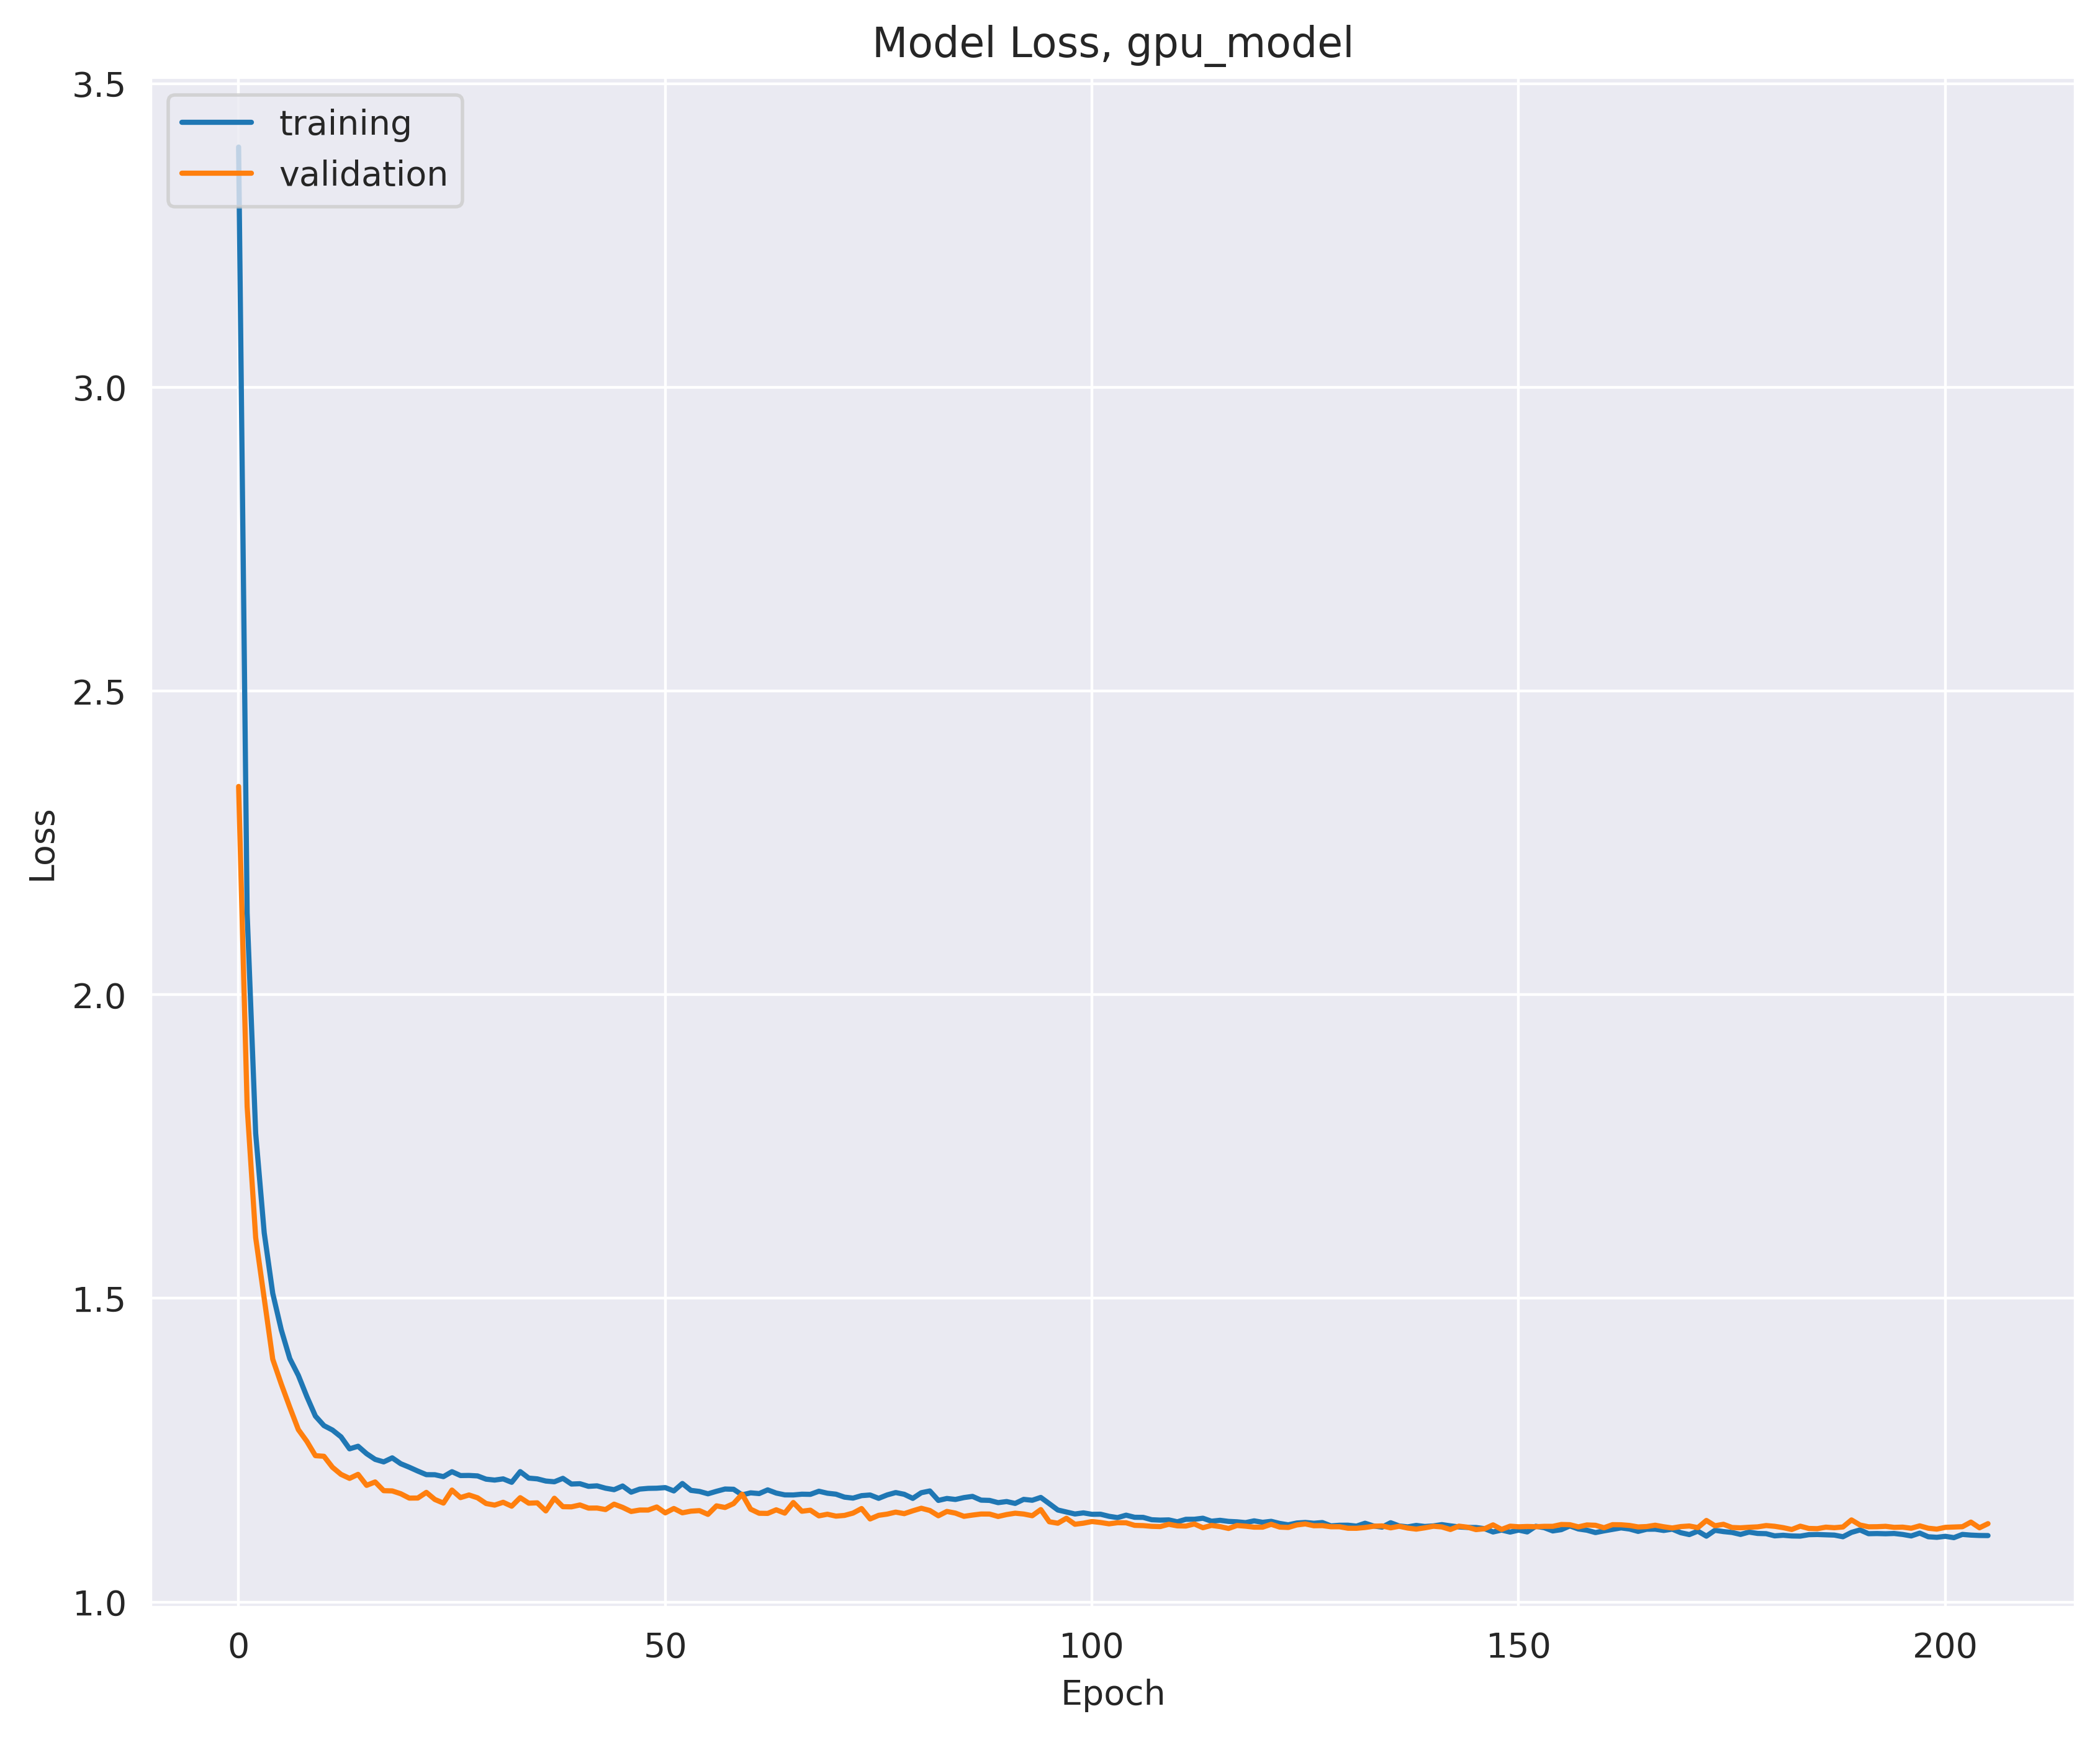

<Figure size 640x480 with 0 Axes>

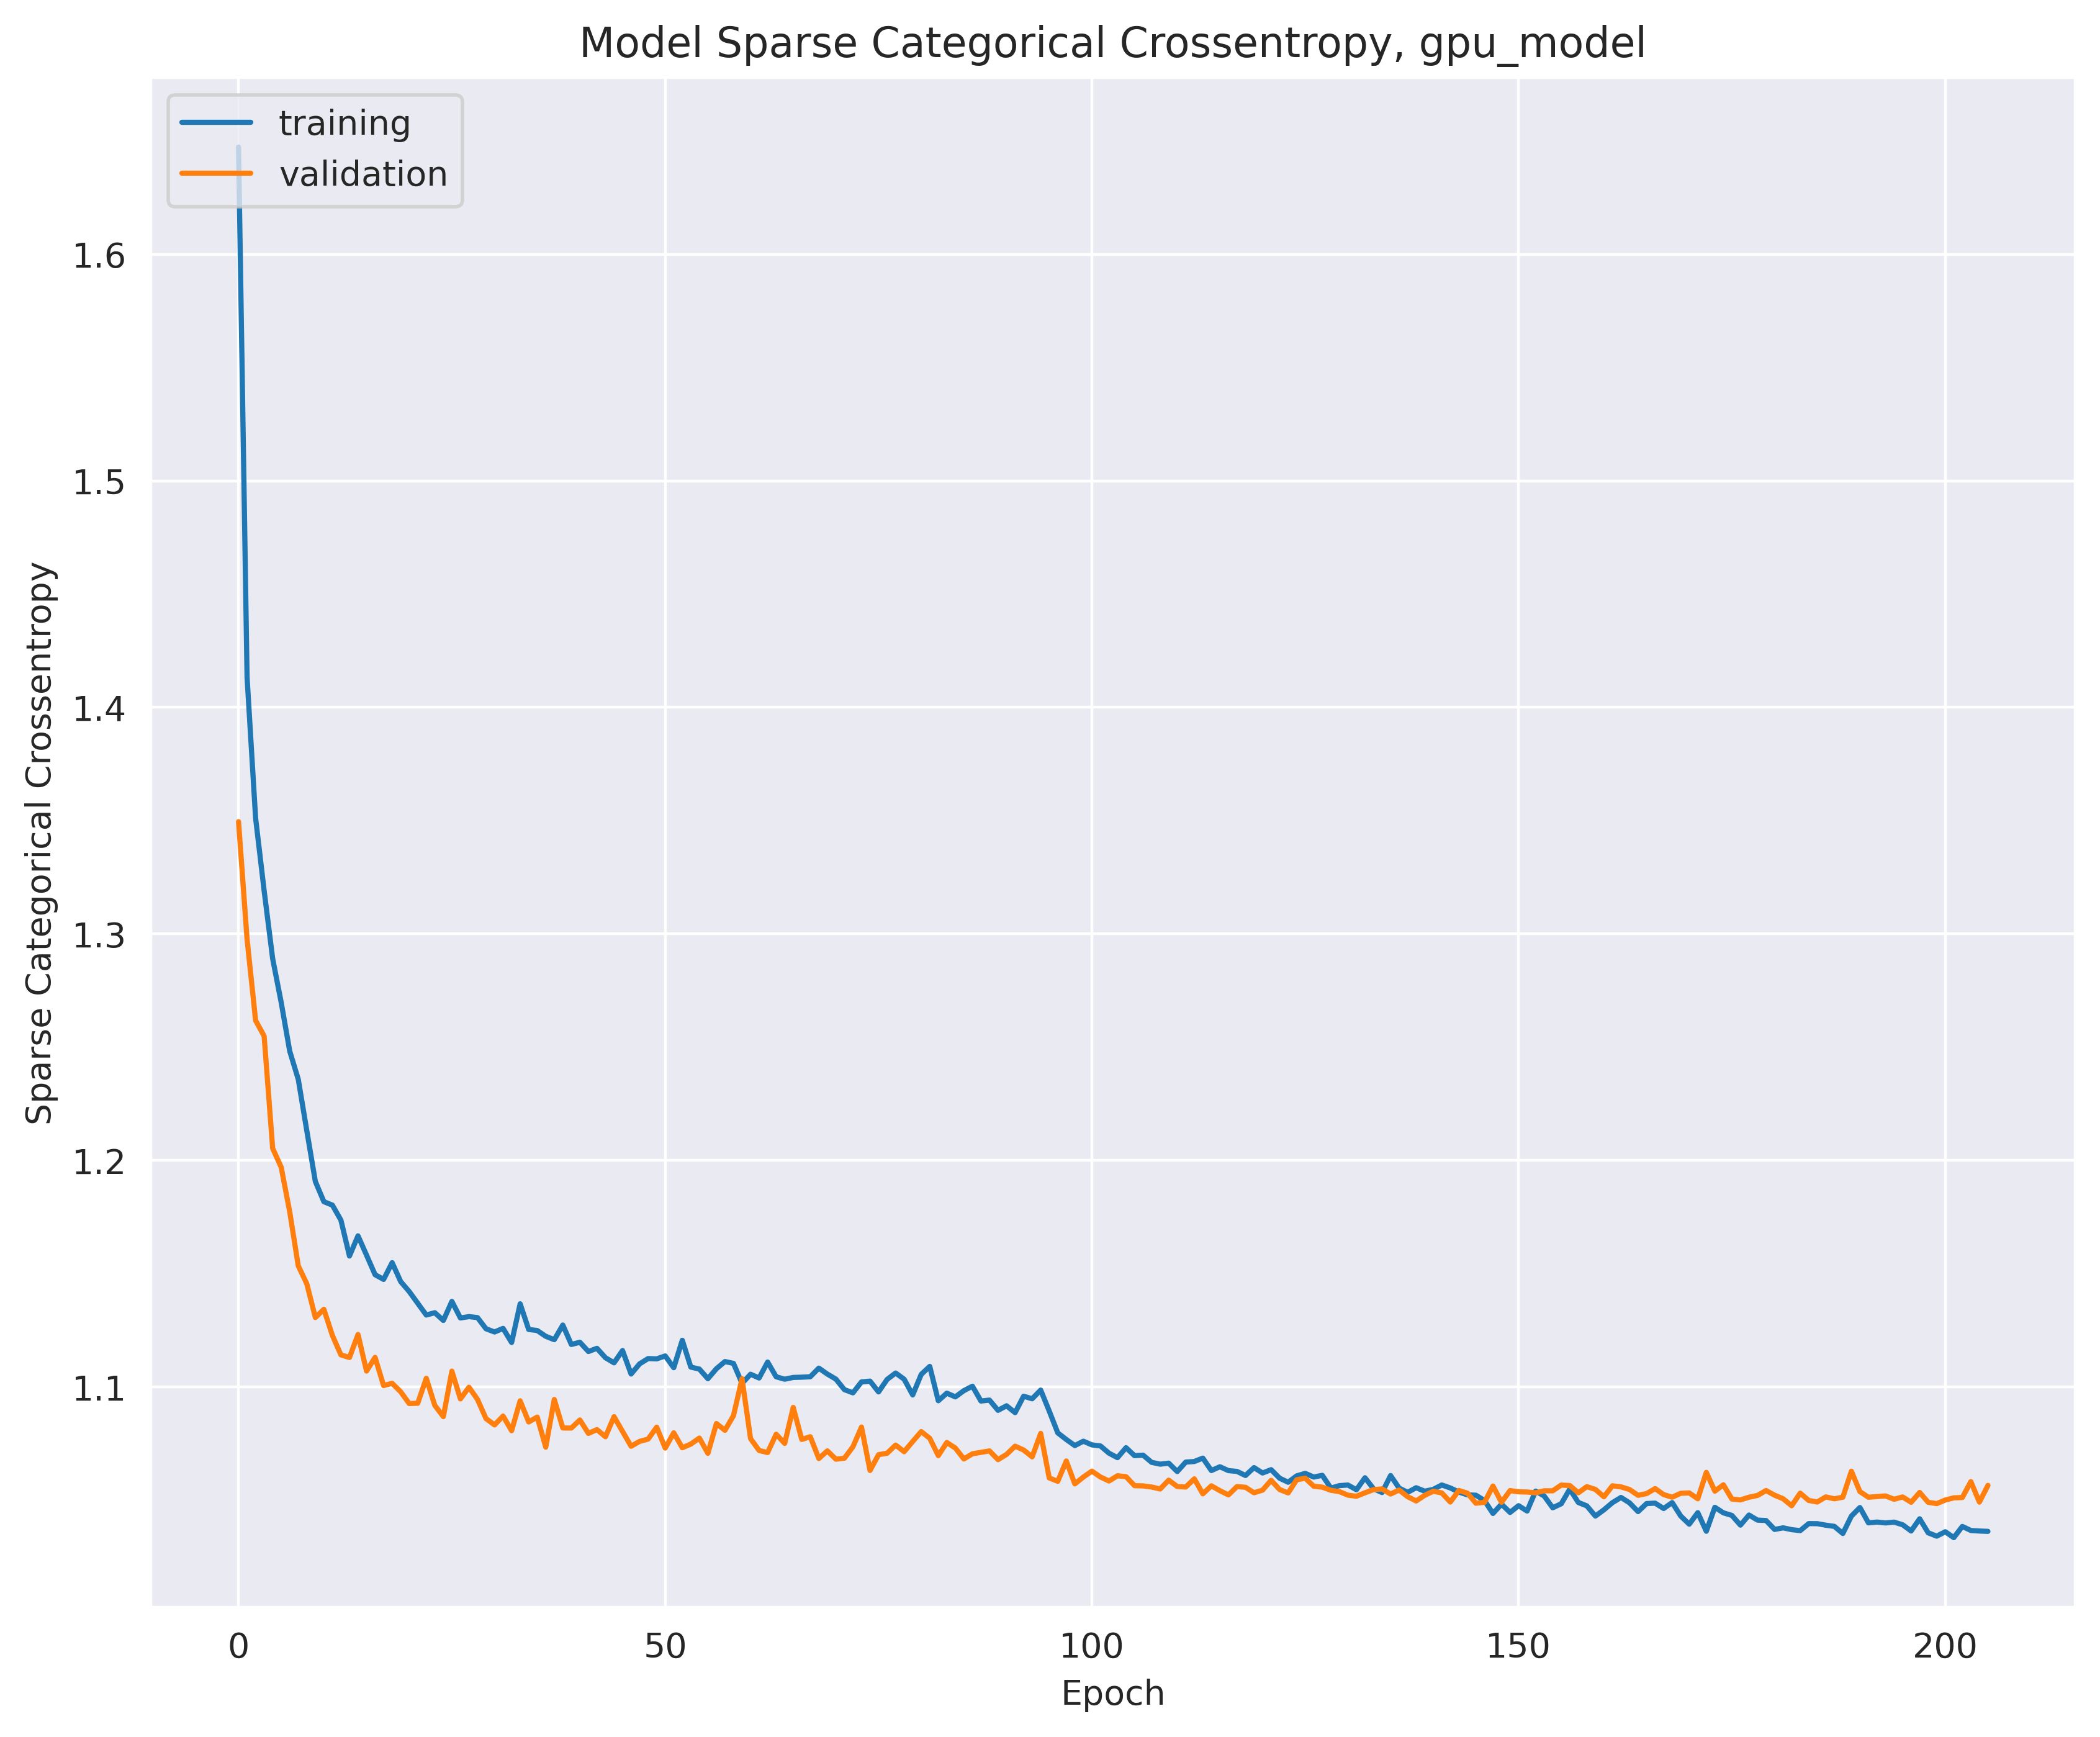

<Figure size 640x480 with 0 Axes>

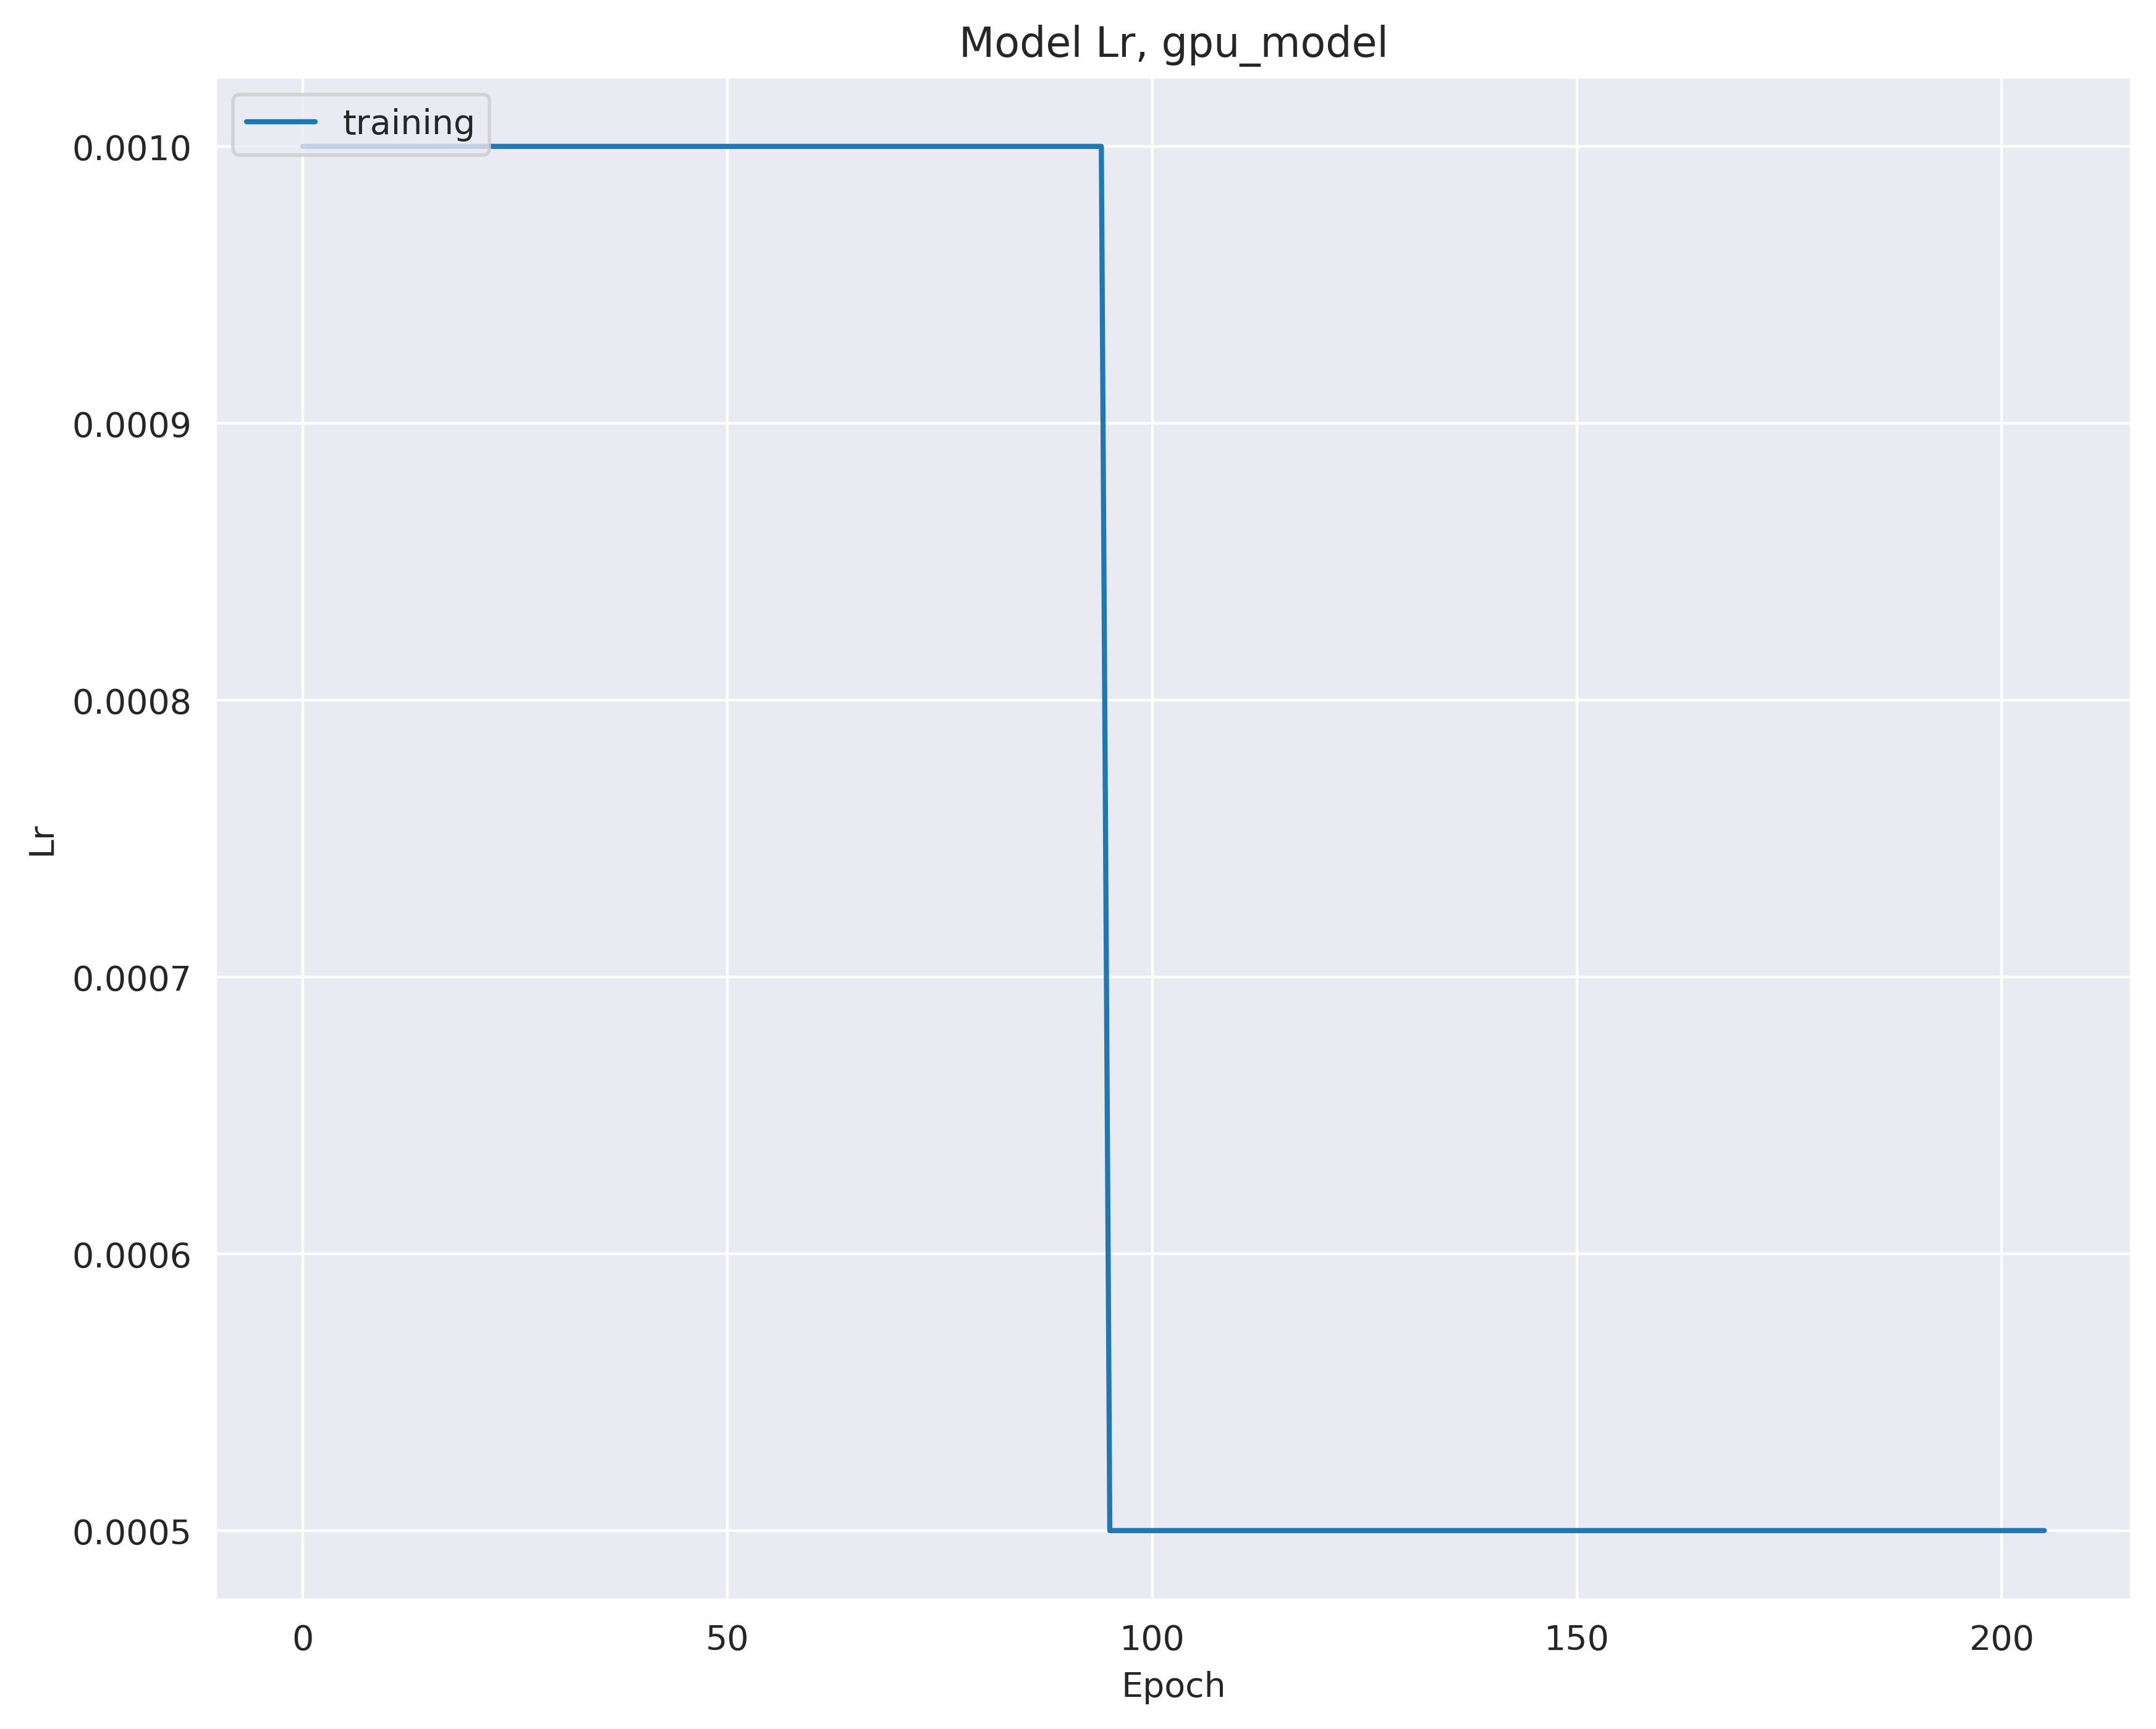

In [16]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "universal"

if add_gpu_prediction:
    model_function = gpu_model_hub
    clf = KerasClassifierModel(
        build_fn=model_function,
        class_number=len(df_notas[target_feature].unique()),
        embedding = embedding,
        epochs=400,
        batch_size=400,
        verbose=10,
    )

    clf.fit(X_train[text_feature], y_train)
    clf.plot_learning_curves('data/output/gpu_model')

In [17]:
if add_gpu_prediction:
    y_pred = clf.predict(X_test[text_feature])
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())

3505/3505 [==============================] - 24s 7ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,2948.000000
1,0.578532,0.889600,0.701111,48469.000000
2,0.756899,0.495760,0.599110,39503.000000
3,0.000000,0.000000,0.000000,5022.000000
4,0.540395,0.454552,0.493770,13950.000000
5,0.000000,0.000000,0.000000,2246.000000
accuracy,0.615697,0.615697,0.615697,0.615697
macro avg,0.312638,0.306652,0.298999,112138.000000
weighted avg,0.583916,0.615697,0.575513,112138.000000


In [18]:
if add_gpu_prediction:
    X_pred = clf.predict(df_merge[text_feature])
    df_merge['GPU_prediction'] = X_pred
    df_merge

4381/4381 [==============================] - 35s 8ms/step


,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,...,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,GPU_prediction
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,1
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,4
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,4
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,4
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,...,0,0,0,0,0,0,0,0,1,1
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,1
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,4
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,...,0,0,0,0,0,1,0,0,0,1


## Hyperparameter Setup

In [19]:
numerical_features = ['Edad'] + list(df_notas.select_dtypes(include='int64').columns)
categorical_features = ['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo']

if 'GPU_prediction' in df_merge:
    categorical_features.append('GPU_prediction')

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    "bootstrap": [True, False],
}
estimator = RandomForestClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta":  np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 100, dtype=float),
    "reg_alpha": np.linspace(0, 10, 100, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    'C': np.linspace(0, 2, 10, dtype=float),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['auto', 'scale'],
    'class_weight': ['balanced'],
}
estimator = SVC()
pipeline.add_estimator(estimator, param_grid)


pipeline.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'más',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                               'este',
     

## Hyperparameter tuning

In [20]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=df_merge[target_feature])

scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }
best_model = pipeline.find_best_model(
    X_train,
    y_train,
    cv=2,
    n_iter=8,
    n_jobs=1,
    scoring=scoring,
    refit='Weighted_F1',
    verbose = 2,
    )

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:51:15] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:51:35] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:51:51] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:52:25] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:53:10] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:53:34] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:54:04] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:54:26] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:54:45] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:55:08] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:55:43] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:55:54] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[01:56:04] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[02:00:03] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[02:03:41] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[02:03:46] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[02:03:55] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [21]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strat...
                               eval_metric=None, gamma=0.25, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.391111106, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0,
                               min_child_weight=5.375, missing=nan,
                               monotone_constraints='()', n_estimators=45,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [22]:
with pd.option_context('display.max_columns', None):
    display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__scale_pos_weight,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,params,split0_test_Accuracy,split1_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
1,33.203526,0.319438,1.843602,0.017627,"CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.775,454.554545,7.777778,1.616162,45,5.375,10,0.25,0.391111,0.4,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.367118,0.372396,0.369757,0.002639,1,0.597602,0.604053,0.600827,0.003225,1
2,24.257069,0.716505,3.007158,0.295923,"CountVectorizer(ngram_range=(2, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.325,55.644444,1.010101,5.757576,67,15.125,8,0.5,0.336667,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.331516,0.339003,0.335259,0.003744,3,0.573521,0.585093,0.579307,0.005786,2
6,226.371319,9.685835,4.066984,0.156710,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),1.0,116.238384,9.494949,1.414141,78,5.375,10,0.25,0.01,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.354635,0.353990,0.354313,0.000323,2,0.567907,0.574202,0.571054,0.003147,3
3,19.682357,1.167024,3.955019,0.010203,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),1.0,267.723232,0.40404,6.969697,23,20.0,2,0.25,0.227778,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.317229,0.313324,0.315277,0.001953,4,0.534460,0.531345,0.532902,0.001557,4
5,7.398219,1.057592,3.221733,0.254775,"CountVectorizer(ngram_range=(2, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),KNNImputer(),VarianceThreshold(),0.325,383.861616,4.444444,6.767677,1,10.25,8,0.75,0.391111,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.293698,0.287212,0.290455,0.003243,5,0.499984,0.498950,0.499467,0.000517,5
4,26.059257,8.251229,2.558402,0.536155,"CountVectorizer(ngram_range=(3, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),SimpleImputer(),SelectFromModel(estimator=ElasticNet()),0.1,409.109091,7.575758,0.30303,34,20.0,8,1.0,0.282222,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.272385,0.275782,0.274084,0.001698,8,0.491573,0.497759,0.494666,0.003093,6
7,3.044981,0.306052,1.800445,0.148412,"CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.1,419.208081,4.242424,1.111111,1,0.5,6,0.75,0.445556,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.274723,0.295610,0.285167,0.010443,6,0.471812,0.505133,0.488472,0.016660,7
0,15.582582,2.201718,2.247754,0.390477,"CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.1,5.149495,7.070707,9.292929,34,10.25,2,0.5,0.227778,0.8

In [23]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
1,1,1,33.203526,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.369757,0.600827
2,2,3,24.257069,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.335259,0.579307
6,3,2,226.371319,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.354313,0.571054
3,4,4,19.682357,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),RobustScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.315277,0.532902
5,5,5,7.398219,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),KNNImputer(),VarianceThreshold(),0.290455,0.499467
4,6,8,26.059257,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),SimpleImputer(),SelectFromModel(estimator=ElasticNet()),0.274084,0.494666
7,7,6,3.044981,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.285167,0.488472
0,8,7,15.582582,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.282010,0.463864


In [28]:
# Retrain the model using a sample-weighting mechanism to try to compensate for the dataset imbalance
if retrain_with_class_weight:
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train,
    )

    best_model.fit(X_train, y_train, estimator__sample_weight=sample_weights)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

[02:12:01] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strat...
                               eval_metric=None, gamma=0.25, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.391111106, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0,
                               min_child_weight=5.375, missing=nan,
                               monotone_constraints='()', n_estimators=45,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

## Scoring

In [29]:
score = pipeline.score(X_test, y_test)
score

,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,0.891774,0.540611,0.590607,0.540611,0.470443,0.571895,"[[1972, 578, 253, 36, 76, 33], [9967, 24865, 6...","[[0.017585475039683246, 0.005154363373700262, ...",precision recall f1-score ...


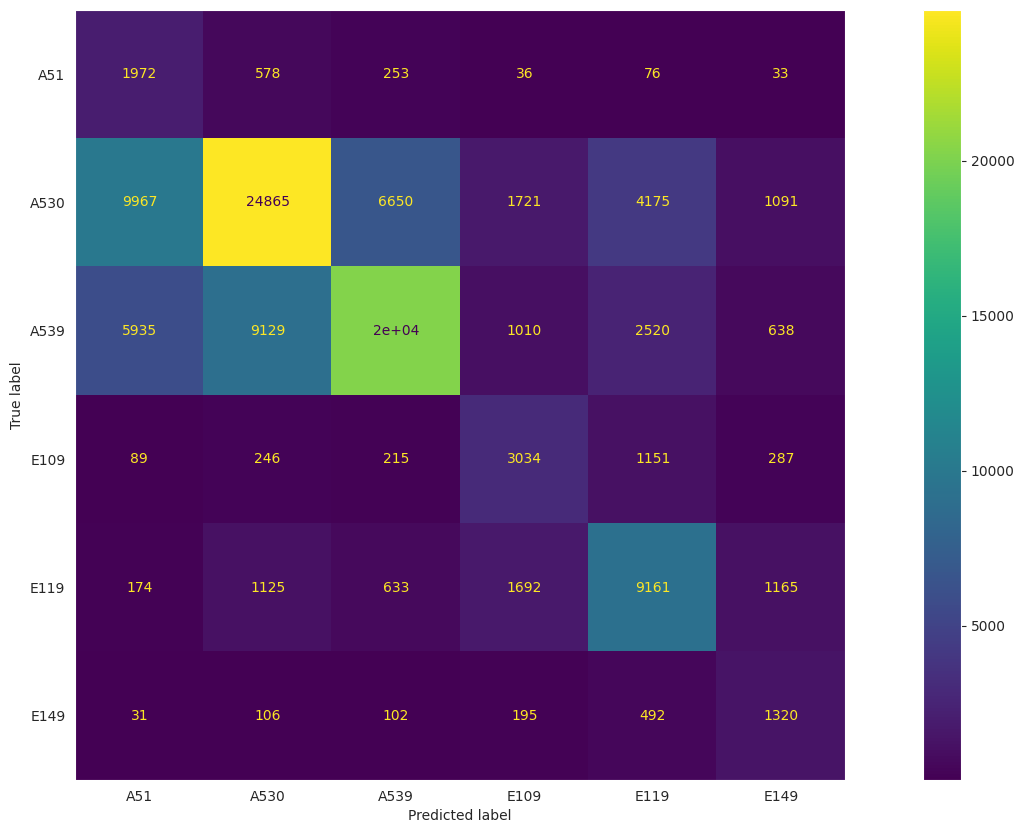

In [30]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

In [31]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A51,0.11,0.67,0.19,2948.00
A530,0.69,0.51,0.59,48469.00
A539,0.72,0.51,0.60,39503.00
E109,0.39,0.60,0.48,5022.00
E119,0.52,0.66,0.58,13950.00
E149,0.29,0.59,0.39,2246.00
accuracy,0.54,0.54,0.54,0.54
macro avg,0.45,0.59,0.47,112138.00
weighted avg,0.64,0.54,0.57,112138.00


## Saving the best performing model

In [ ]:
save_path = Path('data') / 'output' / 'best_model.pickle'
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))